<a href="https://colab.research.google.com/github/Many98/real_estate/blob/models/notebooks/XGboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

zkusit bez gp, price/m^2

In [112]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import max_error
from sklearn.metrics import median_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot
from matplotlib.pyplot import figure
from xgboost import plot_importance

#GET DATA & BASIC ANALYSIS

In [113]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('test_dataset.csv', sep=',', delimiter=None, encoding="utf8")
df_analysis = pd.read_csv('dataset.csv', sep=',', delimiter=None, encoding="utf8")
# drop indexes
df.drop(columns=df.columns[0], axis=1, inplace=True) 
df.describe()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning:

Columns (367,385,388,389,391,392) have mixed types.Specify dtype option on import or set low_memory=False.



,daily_noise,nightly_noise,energy_effeciency_unknown,energy_effeciency_G,energy_effeciency_E,energy_effeciency_B,energy_effeciency_D,energy_effeciency_C,energy_effeciency_A,energy_effeciency_F,ownership_Osobní,ownership_Státní/obecní,ownership_Družstevní,ownership_unknown,equipment_unknown,equipment_ne,equipment_Částečně,equipment_ano,state_unknown,state_V_rekonstrukci,state_Před_rekonstrukcí,state_Po_rekonstrukci,state_Novostavba,state_Velmi_dobrý,state_Dobrý,state_Ve_výstavbě,state_Projekt,state_Špatný,disposition_unknown,disposition_1+kk,disposition_1+1,disposition_3+1,disposition_3+kk,disposition_2+kk,disposition_4+1,disposition_2+1,disposition_5+kk,disposition_4+kk,disposition_atypické,disposition_6_pokojů_a_více,disposition_5+1,disposition_6+kk,construction_type_unknown,construction_type_Cihlová,construction_type_Smíšená,construction_type_Panelová,construction_type_Skeletová,construction_type_Kamenná,construction_type_Montovaná,construction_type_Nízkoenergetická,construction_type_Drevostavba,year_reconstruction_<1950,year_reconstruction_1951-1980,year_reconstruction_1981-2000,year_reconstruction_2001-2010,year_reconstruction_2011-2015,year_reconstruction_2016-2020,year_reconstruction_2021-2025,year_reconstruction_undefined,air_quality_unknown,air_quality_1.0,air_quality_2.0,air_quality_3.0,air_quality_4.0,air_quality_5.0,built_density_unknown,built_density_1.0,built_density_2.0,built_density_3.0,built_density_4.0,built_density_5.0,sun_glare_unknown,sun_glare_1.0,sun_glare_2.0,sun_glare_3.0,sun_glare_4.0,sun_glare_5.0,gas_unknown,gas_True,gas_False,waste_unknown,waste_True,waste_False,telecomunication_unknown,telecomunication_True,telecomunication_False,electricity_unknown,electricity_True,electricity_False,heating_unknown,heating_True,heating_False,bus_station_dist_>=1500m,bus_station_dist_0-99m,bus_station_dist_100-199m,bus_station_dist_200-299m,bus_station_dist_300-399m,bus_station_dist_400-499m,bus_station_dist_500-599m,bus_station_dist_600-699m,bus_station_dist_700-799m,bus_station_dist_800-899m,bus_station_dist_900-999m,bus_station_dist_1000-1099m,bus_station_dist_1100-1199m,bus_station_dist_1200-1299m,bus_station_dist_1300-1399m,bus_station_dist_1400-1499m,train_station_dist_>=1500m,train_station_dist_0-99m,train_station_dist_100-199m,train_station_dist_200-299m,train_station_dist_300-399m,train_station_dist_400-499m,train_station_dist_500-599m,train_station_dist_600-699m,train_station_dist_700-799m,train_station_dist_800-899m,train_station_dist_900-999m,train_station_dist_1000-1099m,train_station_dist_1100-1199m,train_station_dist_1200-1299m,train_station_dist_1300-1399m,train_station_dist_1400-1499m,subway_station_dist_>=1500m,subway_station_dist_0-99m,subway_station_dist_100-199m,subway_station_dist_200-299m,subway_station_dist_300-399m,subway_station_dist_400-499m,subway_station_dist_500-599m,subway_station_dist_600-699m,subway_station_dist_700-799m,subway_station_dist_800-899m,subway_station_dist_900-999m,subway_station_dist_1000-1099m,subway_station_dist_1100-1199m,subway_station_dist_1200-1299m,subway_station_dist_1300-1399m,subway_station_dist_1400-1499m,tram_station_dist_>=1500m,tram_station_dist_0-99m,tram_station_dist_100-199m,tram_station_dist_200-299m,tram_station_dist_300-399m,tram_station_dist_400-499m,tram_station_dist_500-599m,tram_station_dist_600-699m,tram_station_dist_700-799m,tram_station_dist_800-899m,tram_station_dist_900-999m,tram_station_dist_1000-1099m,tram_station_dist_1100-1199m,tram_station_dist_1200-1299m,tram_station_dist_1300-1399m,tram_station_dist_1400-1499m,post_office_dist_>=1500m,post_office_dist_0-99m,post_office_dist_100-199m,post_office_dist_200-299m,post_office_dist_300-399m,post_office_dist_400-499m,post_office_dist_500-599m,post_office_dist_600-699m,post_office_dist_700-799m,post_office_dist_800-899m,post_office_dist_900-999m,post_office_dist_1000-1099m,post_office_dist_1100-1199m,post_office_dist_1200-1299m,post_office_dist_1300-1399m,post_office_dist_1400-1499m,atm_dist_

In [114]:
# drop non-usable columns
df.drop("floor_area", axis=1, inplace=True) 
df.drop("desc_hash", axis=1, inplace=True) 
df.drop("hash", axis=1, inplace=True) 
# drop texts columns
df.drop("description", axis=1, inplace=True) # from nlp
df.drop("note", axis=1, inplace=True) # from nlp
df.drop("header", axis=1, inplace=True) # from nlp
df.drop("heating_txt", axis=1, inplace=True)
df.drop("waste_txt", axis=1, inplace=True)
df.drop("telecomunication_txt", axis=1, inplace=True)
df.drop("electricity_txt", axis=1, inplace=True)
df.drop("tags", axis=1, inplace=True)
df.drop("geometry", axis=1, inplace=True)
df.drop("additional_disposition", axis=1, inplace=True) 
df.drop("transport", axis=1, inplace=True) 
df.drop("name", axis=1, inplace=True) 
df.drop("place", axis=1, inplace=True) # praha 1 apod.
df.drop("date", axis=1, inplace=True) # later transform into float (2018+2/12)

In [115]:
# for error feature_names may not contain [, ] or <
df.columns = df.columns.str.replace(r'.', '_')
df.columns = df.columns.str.replace(r'-', '_')
df.columns = df.columns.str.replace(r'>=', '_vetsi_rovno_')
df.columns = df.columns.str.replace(r'+', '_plus_')
df.columns = df.columns.str.replace(r' ', '_')
df.columns = df.columns.str.replace(r'/', '_')
df.columns = df.columns.str.replace(r'[', '_')
df.columns = df.columns.str.replace(r']', '_')
df.columns = df.columns.str.replace(r'<', 'mensi')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular

In [116]:
# columns with embeddings
only_embeddings = [i for i in df.columns if 'emb' in i]
df = df.drop([emb for emb in only_embeddings], axis=1)
# only ordinal columns 
only_ord = [i for i in df.columns if 'ord' in i]

# columns with ordinal distance
only_ord_dist = [i for i in df.columns if 'dist' in i and 'ord' in i and 'num' not in i and 'city' not in i]
# only numerical dist columns (with indicator >=1500m)
only_num_dist = [i for i in df.columns if 'dist' in i and 'ord' not in i and 'num' in i and 'city' not in i] + \
                [i for i in df.columns if '1500m' in i]
# only one-hot encoded distances
only_one_hot_dist = [i for i in df.columns if 'dist' in i and 'ord' not in i and
                     'num' not in i and 'city' not in i]
only_one_hot_100m = [i for i in df.columns if '0-99m' in i]
# only coordinates
only_coords = ['long', 'lat']
# Gaussian process predicition
only_gp = [i for i in df.columns if 'gp' in i]
# noise
only_noise = [i for i in df.columns if 'noise' in i]
# quality
only_quality_ord = [i for i in df.columns if ('quality' in i or
                'sun' in i or 'built' in i) and 'ord' in i]
# one hotncoded energy effeciency
only_energy = [i for i in df.columns if 'energy_effeciency' in i and 'ord' not in i]
# disposition
only_disposition = [i for i in df.columns if 'disposition' in i]
# construction_type
only_construction = [i for i in df.columns if 'construction_t' in i]
# ownership
only_ownership = [i for i in df.columns if 'ownership' in i]
# equipment
only_equipment = [i for i in df.columns if 'equipment' in i]
# state
only_state = [i for i in df.columns if 'state' in i]
# only has_<> features
only_has = [i for i in df.columns if 'has' in i]

In [117]:
# e.g. when u want columns without embeddings and without ordinal features and without
#one-hot encoded ditances do something like that
df1 = df[df.columns.difference(only_embeddings + only_ord + only_one_hot_dist)]

In [118]:
df.head()

,daily_noise,nightly_noise,energy_effeciency_unknown,energy_effeciency_G,energy_effeciency_E,energy_effeciency_B,energy_effeciency_D,energy_effeciency_C,energy_effeciency_A,energy_effeciency_F,ownership_Osobní,ownership_Státní_obecní,ownership_Družstevní,ownership_unknown,equipment_unknown,equipment_ne,equipment_Částečně,equipment_ano,state_unknown,state_V_rekonstrukci,state_Před_rekonstrukcí,state_Po_rekonstrukci,state_Novostavba,state_Velmi_dobrý,state_Dobrý,state_Ve_výstavbě,state_Projekt,state_Špatný,disposition_unknown,disposition_1_plus_kk,disposition_1_plus_1,disposition_3_plus_1,disposition_3_plus_kk,disposition_2_plus_kk,disposition_4_plus_1,disposition_2_plus_1,disposition_5_plus_kk,disposition_4_plus_kk,disposition_atypické,disposition_6_pokojů_a_více,disposition_5_plus_1,disposition_6_plus_kk,construction_type_unknown,construction_type_Cihlová,construction_type_Smíšená,construction_type_Panelová,construction_type_Skeletová,construction_type_Kamenná,construction_type_Montovaná,construction_type_Nízkoenergetická,construction_type_Drevostavba,year_reconstruction_mensi1950,year_reconstruction_1951_1980,year_reconstruction_1981_2000,year_reconstruction_2001_2010,year_reconstruction_2011_2015,year_reconstruction_2016_2020,year_reconstruction_2021_2025,year_reconstruction_undefined,air_quality_unknown,air_quality_1_0,air_quality_2_0,air_quality_3_0,air_quality_4_0,air_quality_5_0,built_density_unknown,built_density_1_0,built_density_2_0,built_density_3_0,built_density_4_0,built_density_5_0,sun_glare_unknown,sun_glare_1_0,sun_glare_2_0,sun_glare_3_0,sun_glare_4_0,sun_glare_5_0,gas_unknown,gas_True,gas_False,waste_unknown,waste_True,waste_False,telecomunication_unknown,telecomunication_True,telecomunication_False,electricity_unknown,electricity_True,electricity_False,heating_unknown,heating_True,heating_False,bus_station_dist__vetsi_rovno_1500m,bus_station_dist_0_99m,bus_station_dist_100_199m,bus_station_dist_200_299m,bus_station_dist_300_399m,bus_station_dist_400_499m,bus_station_dist_500_599m,bus_station_dist_600_699m,bus_station_dist_700_799m,bus_station_dist_800_899m,bus_station_dist_900_999m,bus_station_dist_1000_1099m,bus_station_dist_1100_1199m,bus_station_dist_1200_1299m,bus_station_dist_1300_1399m,bus_station_dist_1400_1499m,train_station_dist__vetsi_rovno_1500m,train_station_dist_0_99m,train_station_dist_100_199m,train_station_dist_200_299m,train_station_dist_300_399m,train_station_dist_400_499m,train_station_dist_500_599m,train_station_dist_600_699m,train_station_dist_700_799m,train_station_dist_800_899m,train_station_dist_900_999m,train_station_dist_1000_1099m,train_station_dist_1100_1199m,train_station_dist_1200_1299m,train_station_dist_1300_1399m,train_station_dist_1400_1499m,subway_station_dist__vetsi_rovno_1500m,subway_station_dist_0_99m,subway_station_dist_100_199m,subway_station_dist_200_299m,subway_station_dist_300_399m,subway_station_dist_400_499m,subway_station_dist_500_599m,subway_station_dist_600_699m,subway_station_dist_700_799m,subway_station_dist_800_899m,subway_station_dist_900_999m,subway_station_dist_1000_1099m,subway_station_dist_1100_1199m,subway_station_dist_1200_1299m,subway_station_dist_1300_1399m,subway_station_dist_1400_1499m,tram_station_dist__vetsi_rovno_1500m,tram_station_dist_0_99m,tram_station_dist_100_199m,tram_station_dist_200_299m,tram_station_dist_300_399m,tram_station_dist_400_499m,tram_station_dist_500_599m,tram_station_dist_600_699m,tram_station_dist_700_799m,tram_station_dist_800_899m,tram_station_dist_900_999m,tram_station_dist_1000_1099m,tram_station_dist_1100_1199m,tram_station_dist_1200_1299m,tram_station_dist_1300_1399m,tram_station_dist_1400_1499m,post_office_dist__vetsi_rovno_1500m,post_office_dist_0_99m,post_office_dist_100_199m,post_office_dist_200_299m,post_office_dist_300_399m,post_office_dist_400_499m,post_office_dist_500_599m,post_office_dist_600_699m,post_office_dist_700_799m,post_office_dist_800_899m,post_office_dist_900_999m,post_office_dist_1000_1099m,post_of

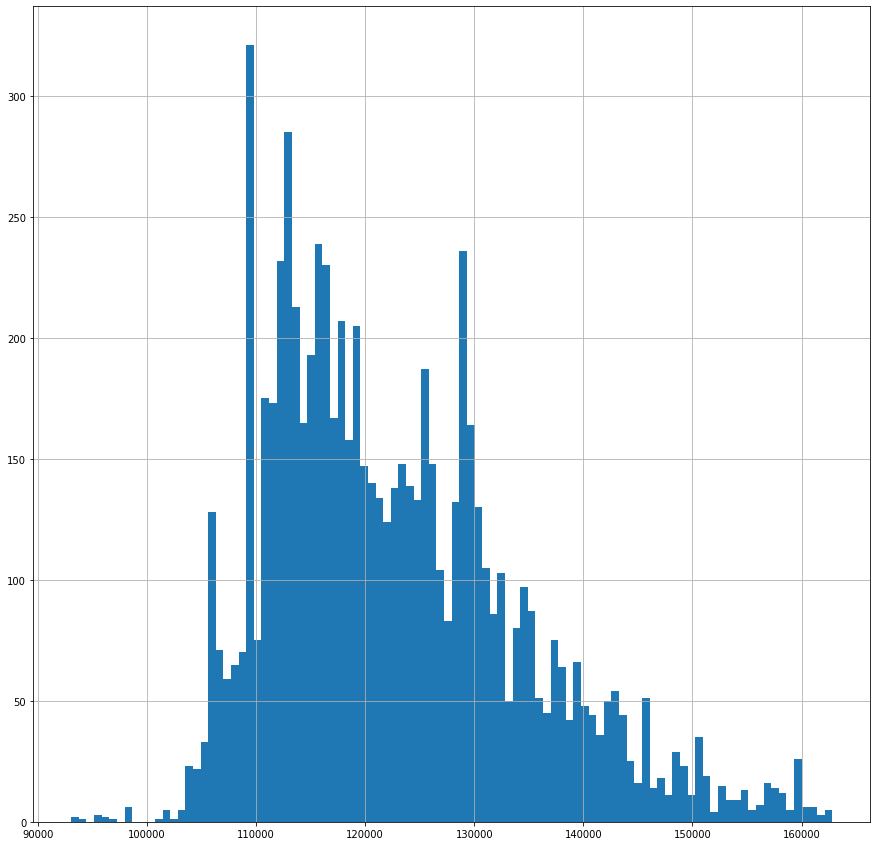

In [119]:
hist = df["gp_mean_price"].hist(bins=100)

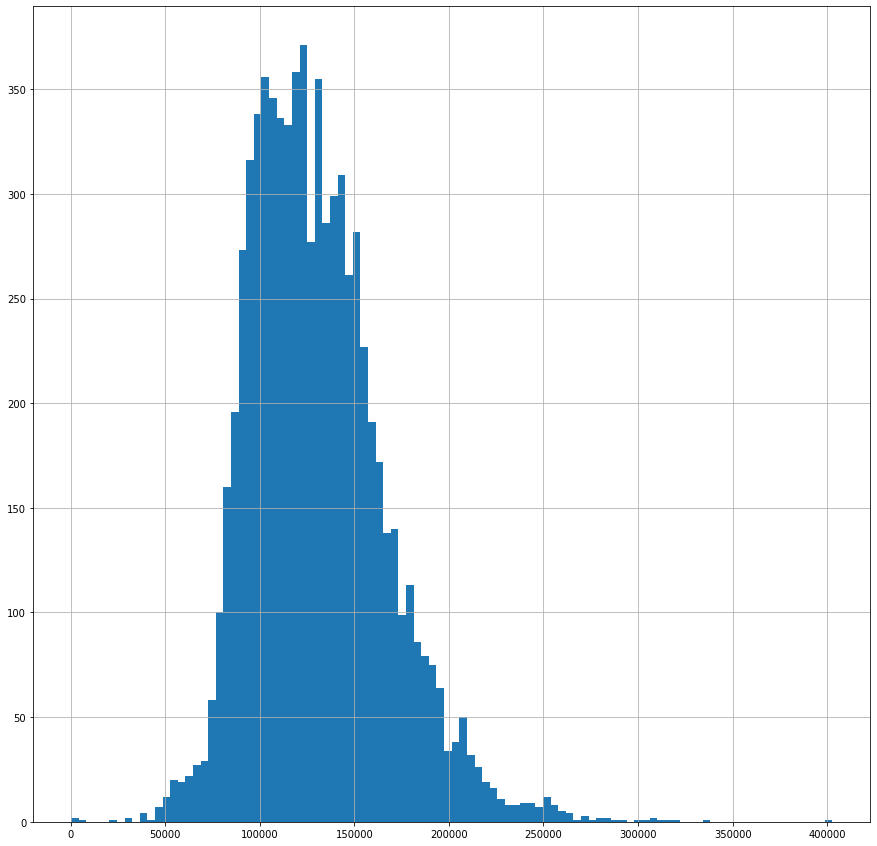

In [120]:
df['price_m2'] = df["price"]/df["usable_area"]
hist = df["price_m2"].hist(bins=100)

In [121]:
fig = px.box(df, y="gp_mean_price")
fig.show()

In [122]:
fig = px.box(df, y="price_m2")
fig.show()

In [123]:
df[df.price_m2 < 30000] # byty za 25000 a 23000 jenom? - Prodej podílu 1/345 bytu 3+kk 57 m² - inzerát: https://www.sreality.cz/hledani/prodej/byty/praha?cena-od=0&cena-do=25000

,daily_noise,nightly_noise,energy_effeciency_unknown,energy_effeciency_G,energy_effeciency_E,energy_effeciency_B,energy_effeciency_D,energy_effeciency_C,energy_effeciency_A,energy_effeciency_F,ownership_Osobní,ownership_Státní_obecní,ownership_Družstevní,ownership_unknown,equipment_unknown,equipment_ne,equipment_Částečně,equipment_ano,state_unknown,state_V_rekonstrukci,state_Před_rekonstrukcí,state_Po_rekonstrukci,state_Novostavba,state_Velmi_dobrý,state_Dobrý,state_Ve_výstavbě,state_Projekt,state_Špatný,disposition_unknown,disposition_1_plus_kk,disposition_1_plus_1,disposition_3_plus_1,disposition_3_plus_kk,disposition_2_plus_kk,disposition_4_plus_1,disposition_2_plus_1,disposition_5_plus_kk,disposition_4_plus_kk,disposition_atypické,disposition_6_pokojů_a_více,disposition_5_plus_1,disposition_6_plus_kk,construction_type_unknown,construction_type_Cihlová,construction_type_Smíšená,construction_type_Panelová,construction_type_Skeletová,construction_type_Kamenná,construction_type_Montovaná,construction_type_Nízkoenergetická,construction_type_Drevostavba,year_reconstruction_mensi1950,year_reconstruction_1951_1980,year_reconstruction_1981_2000,year_reconstruction_2001_2010,year_reconstruction_2011_2015,year_reconstruction_2016_2020,year_reconstruction_2021_2025,year_reconstruction_undefined,air_quality_unknown,air_quality_1_0,air_quality_2_0,air_quality_3_0,air_quality_4_0,air_quality_5_0,built_density_unknown,built_density_1_0,built_density_2_0,built_density_3_0,built_density_4_0,built_density_5_0,sun_glare_unknown,sun_glare_1_0,sun_glare_2_0,sun_glare_3_0,sun_glare_4_0,sun_glare_5_0,gas_unknown,gas_True,gas_False,waste_unknown,waste_True,waste_False,telecomunication_unknown,telecomunication_True,telecomunication_False,electricity_unknown,electricity_True,electricity_False,heating_unknown,heating_True,heating_False,bus_station_dist__vetsi_rovno_1500m,bus_station_dist_0_99m,bus_station_dist_100_199m,bus_station_dist_200_299m,bus_station_dist_300_399m,bus_station_dist_400_499m,bus_station_dist_500_599m,bus_station_dist_600_699m,bus_station_dist_700_799m,bus_station_dist_800_899m,bus_station_dist_900_999m,bus_station_dist_1000_1099m,bus_station_dist_1100_1199m,bus_station_dist_1200_1299m,bus_station_dist_1300_1399m,bus_station_dist_1400_1499m,train_station_dist__vetsi_rovno_1500m,train_station_dist_0_99m,train_station_dist_100_199m,train_station_dist_200_299m,train_station_dist_300_399m,train_station_dist_400_499m,train_station_dist_500_599m,train_station_dist_600_699m,train_station_dist_700_799m,train_station_dist_800_899m,train_station_dist_900_999m,train_station_dist_1000_1099m,train_station_dist_1100_1199m,train_station_dist_1200_1299m,train_station_dist_1300_1399m,train_station_dist_1400_1499m,subway_station_dist__vetsi_rovno_1500m,subway_station_dist_0_99m,subway_station_dist_100_199m,subway_station_dist_200_299m,subway_station_dist_300_399m,subway_station_dist_400_499m,subway_station_dist_500_599m,subway_station_dist_600_699m,subway_station_dist_700_799m,subway_station_dist_800_899m,subway_station_dist_900_999m,subway_station_dist_1000_1099m,subway_station_dist_1100_1199m,subway_station_dist_1200_1299m,subway_station_dist_1300_1399m,subway_station_dist_1400_1499m,tram_station_dist__vetsi_rovno_1500m,tram_station_dist_0_99m,tram_station_dist_100_199m,tram_station_dist_200_299m,tram_station_dist_300_399m,tram_station_dist_400_499m,tram_station_dist_500_599m,tram_station_dist_600_699m,tram_station_dist_700_799m,tram_station_dist_800_899m,tram_station_dist_900_999m,tram_station_dist_1000_1099m,tram_station_dist_1100_1199m,tram_station_dist_1200_1299m,tram_station_dist_1300_1399m,tram_station_dist_1400_1499m,post_office_dist__vetsi_rovno_1500m,post_office_dist_0_99m,post_office_dist_100_199m,post_office_dist_200_299m,post_office_dist_300_399m,post_office_dist_400_499m,post_office_dist_500_599m,post_office_dist_600_699m,post_office_dist_700_799m,post_office_dist_800_899m,post_office_dist_900_999m,post_office_dist_1000_1099m,post_of

In [124]:
df[df.price_m2 > 400000] # https://www.sreality.cz/detail/prodej/byt/2+kk/praha-vysocany-podebradska/4035192396 - chyba v inzerátu

,daily_noise,nightly_noise,energy_effeciency_unknown,energy_effeciency_G,energy_effeciency_E,energy_effeciency_B,energy_effeciency_D,energy_effeciency_C,energy_effeciency_A,energy_effeciency_F,ownership_Osobní,ownership_Státní_obecní,ownership_Družstevní,ownership_unknown,equipment_unknown,equipment_ne,equipment_Částečně,equipment_ano,state_unknown,state_V_rekonstrukci,state_Před_rekonstrukcí,state_Po_rekonstrukci,state_Novostavba,state_Velmi_dobrý,state_Dobrý,state_Ve_výstavbě,state_Projekt,state_Špatný,disposition_unknown,disposition_1_plus_kk,disposition_1_plus_1,disposition_3_plus_1,disposition_3_plus_kk,disposition_2_plus_kk,disposition_4_plus_1,disposition_2_plus_1,disposition_5_plus_kk,disposition_4_plus_kk,disposition_atypické,disposition_6_pokojů_a_více,disposition_5_plus_1,disposition_6_plus_kk,construction_type_unknown,construction_type_Cihlová,construction_type_Smíšená,construction_type_Panelová,construction_type_Skeletová,construction_type_Kamenná,construction_type_Montovaná,construction_type_Nízkoenergetická,construction_type_Drevostavba,year_reconstruction_mensi1950,year_reconstruction_1951_1980,year_reconstruction_1981_2000,year_reconstruction_2001_2010,year_reconstruction_2011_2015,year_reconstruction_2016_2020,year_reconstruction_2021_2025,year_reconstruction_undefined,air_quality_unknown,air_quality_1_0,air_quality_2_0,air_quality_3_0,air_quality_4_0,air_quality_5_0,built_density_unknown,built_density_1_0,built_density_2_0,built_density_3_0,built_density_4_0,built_density_5_0,sun_glare_unknown,sun_glare_1_0,sun_glare_2_0,sun_glare_3_0,sun_glare_4_0,sun_glare_5_0,gas_unknown,gas_True,gas_False,waste_unknown,waste_True,waste_False,telecomunication_unknown,telecomunication_True,telecomunication_False,electricity_unknown,electricity_True,electricity_False,heating_unknown,heating_True,heating_False,bus_station_dist__vetsi_rovno_1500m,bus_station_dist_0_99m,bus_station_dist_100_199m,bus_station_dist_200_299m,bus_station_dist_300_399m,bus_station_dist_400_499m,bus_station_dist_500_599m,bus_station_dist_600_699m,bus_station_dist_700_799m,bus_station_dist_800_899m,bus_station_dist_900_999m,bus_station_dist_1000_1099m,bus_station_dist_1100_1199m,bus_station_dist_1200_1299m,bus_station_dist_1300_1399m,bus_station_dist_1400_1499m,train_station_dist__vetsi_rovno_1500m,train_station_dist_0_99m,train_station_dist_100_199m,train_station_dist_200_299m,train_station_dist_300_399m,train_station_dist_400_499m,train_station_dist_500_599m,train_station_dist_600_699m,train_station_dist_700_799m,train_station_dist_800_899m,train_station_dist_900_999m,train_station_dist_1000_1099m,train_station_dist_1100_1199m,train_station_dist_1200_1299m,train_station_dist_1300_1399m,train_station_dist_1400_1499m,subway_station_dist__vetsi_rovno_1500m,subway_station_dist_0_99m,subway_station_dist_100_199m,subway_station_dist_200_299m,subway_station_dist_300_399m,subway_station_dist_400_499m,subway_station_dist_500_599m,subway_station_dist_600_699m,subway_station_dist_700_799m,subway_station_dist_800_899m,subway_station_dist_900_999m,subway_station_dist_1000_1099m,subway_station_dist_1100_1199m,subway_station_dist_1200_1299m,subway_station_dist_1300_1399m,subway_station_dist_1400_1499m,tram_station_dist__vetsi_rovno_1500m,tram_station_dist_0_99m,tram_station_dist_100_199m,tram_station_dist_200_299m,tram_station_dist_300_399m,tram_station_dist_400_499m,tram_station_dist_500_599m,tram_station_dist_600_699m,tram_station_dist_700_799m,tram_station_dist_800_899m,tram_station_dist_900_999m,tram_station_dist_1000_1099m,tram_station_dist_1100_1199m,tram_station_dist_1200_1299m,tram_station_dist_1300_1399m,tram_station_dist_1400_1499m,post_office_dist__vetsi_rovno_1500m,post_office_dist_0_99m,post_office_dist_100_199m,post_office_dist_200_299m,post_office_dist_300_399m,post_office_dist_400_499m,post_office_dist_500_599m,post_office_dist_600_699m,post_office_dist_700_799m,post_office_dist_800_899m,post_office_dist_900_999m,post_office_dist_1000_1099m,post_of

In [125]:
# keep flats > 35 000/m^2 and < 350 000/m^2
df = df[df.price_m2 > 40000]
df = df[df.price_m2 < 350000]
df = df[df.floor < 20]
df = df[df.floor > -1]

In [126]:
fig = px.box(df, y="price_m2")
fig.show()

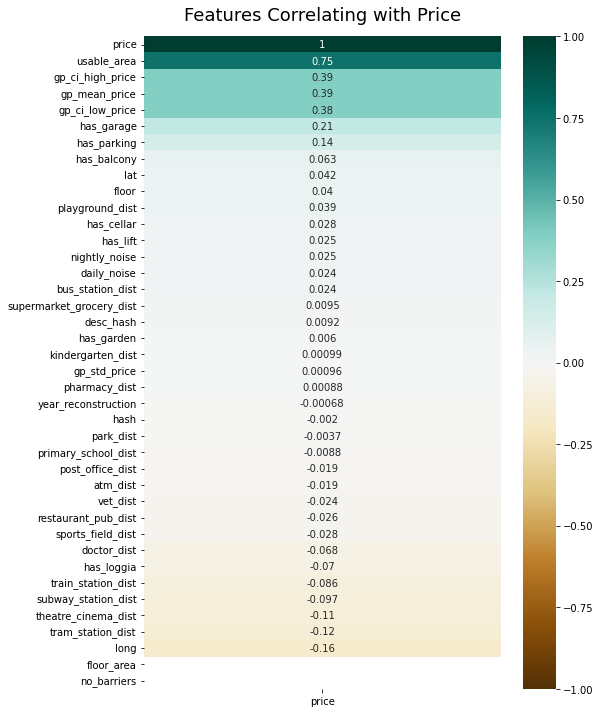

In [127]:
df_analysis.corr()[['price']].sort_values(by='price', ascending=False)
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df_analysis.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Price', fontdict={'fontsize':18}, pad=16);

In [128]:
df.drop("price_m2", axis=1, inplace=True)

In [129]:
df.head()

,daily_noise,nightly_noise,energy_effeciency_unknown,energy_effeciency_G,energy_effeciency_E,energy_effeciency_B,energy_effeciency_D,energy_effeciency_C,energy_effeciency_A,energy_effeciency_F,ownership_Osobní,ownership_Státní_obecní,ownership_Družstevní,ownership_unknown,equipment_unknown,equipment_ne,equipment_Částečně,equipment_ano,state_unknown,state_V_rekonstrukci,state_Před_rekonstrukcí,state_Po_rekonstrukci,state_Novostavba,state_Velmi_dobrý,state_Dobrý,state_Ve_výstavbě,state_Projekt,state_Špatný,disposition_unknown,disposition_1_plus_kk,disposition_1_plus_1,disposition_3_plus_1,disposition_3_plus_kk,disposition_2_plus_kk,disposition_4_plus_1,disposition_2_plus_1,disposition_5_plus_kk,disposition_4_plus_kk,disposition_atypické,disposition_6_pokojů_a_více,disposition_5_plus_1,disposition_6_plus_kk,construction_type_unknown,construction_type_Cihlová,construction_type_Smíšená,construction_type_Panelová,construction_type_Skeletová,construction_type_Kamenná,construction_type_Montovaná,construction_type_Nízkoenergetická,construction_type_Drevostavba,year_reconstruction_mensi1950,year_reconstruction_1951_1980,year_reconstruction_1981_2000,year_reconstruction_2001_2010,year_reconstruction_2011_2015,year_reconstruction_2016_2020,year_reconstruction_2021_2025,year_reconstruction_undefined,air_quality_unknown,air_quality_1_0,air_quality_2_0,air_quality_3_0,air_quality_4_0,air_quality_5_0,built_density_unknown,built_density_1_0,built_density_2_0,built_density_3_0,built_density_4_0,built_density_5_0,sun_glare_unknown,sun_glare_1_0,sun_glare_2_0,sun_glare_3_0,sun_glare_4_0,sun_glare_5_0,gas_unknown,gas_True,gas_False,waste_unknown,waste_True,waste_False,telecomunication_unknown,telecomunication_True,telecomunication_False,electricity_unknown,electricity_True,electricity_False,heating_unknown,heating_True,heating_False,bus_station_dist__vetsi_rovno_1500m,bus_station_dist_0_99m,bus_station_dist_100_199m,bus_station_dist_200_299m,bus_station_dist_300_399m,bus_station_dist_400_499m,bus_station_dist_500_599m,bus_station_dist_600_699m,bus_station_dist_700_799m,bus_station_dist_800_899m,bus_station_dist_900_999m,bus_station_dist_1000_1099m,bus_station_dist_1100_1199m,bus_station_dist_1200_1299m,bus_station_dist_1300_1399m,bus_station_dist_1400_1499m,train_station_dist__vetsi_rovno_1500m,train_station_dist_0_99m,train_station_dist_100_199m,train_station_dist_200_299m,train_station_dist_300_399m,train_station_dist_400_499m,train_station_dist_500_599m,train_station_dist_600_699m,train_station_dist_700_799m,train_station_dist_800_899m,train_station_dist_900_999m,train_station_dist_1000_1099m,train_station_dist_1100_1199m,train_station_dist_1200_1299m,train_station_dist_1300_1399m,train_station_dist_1400_1499m,subway_station_dist__vetsi_rovno_1500m,subway_station_dist_0_99m,subway_station_dist_100_199m,subway_station_dist_200_299m,subway_station_dist_300_399m,subway_station_dist_400_499m,subway_station_dist_500_599m,subway_station_dist_600_699m,subway_station_dist_700_799m,subway_station_dist_800_899m,subway_station_dist_900_999m,subway_station_dist_1000_1099m,subway_station_dist_1100_1199m,subway_station_dist_1200_1299m,subway_station_dist_1300_1399m,subway_station_dist_1400_1499m,tram_station_dist__vetsi_rovno_1500m,tram_station_dist_0_99m,tram_station_dist_100_199m,tram_station_dist_200_299m,tram_station_dist_300_399m,tram_station_dist_400_499m,tram_station_dist_500_599m,tram_station_dist_600_699m,tram_station_dist_700_799m,tram_station_dist_800_899m,tram_station_dist_900_999m,tram_station_dist_1000_1099m,tram_station_dist_1100_1199m,tram_station_dist_1200_1299m,tram_station_dist_1300_1399m,tram_station_dist_1400_1499m,post_office_dist__vetsi_rovno_1500m,post_office_dist_0_99m,post_office_dist_100_199m,post_office_dist_200_299m,post_office_dist_300_399m,post_office_dist_400_499m,post_office_dist_500_599m,post_office_dist_600_699m,post_office_dist_700_799m,post_office_dist_800_899m,post_office_dist_900_999m,post_office_dist_1000_1099m,post_of

# XGBoost quantile

In [130]:
class XGBQuantile(XGBRegressor):
  def __init__(self,quant_alpha=0.95,quant_delta = 1.0,quant_thres=1.0,quant_var =1.0,base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
                n_jobs=1, nthread=None, objective='reg:linear', random_state=0,reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,silent=True, subsample=1):
    self.quant_alpha = quant_alpha
    self.quant_delta = quant_delta
    self.quant_thres = quant_thres
    self.quant_var = quant_var
    
    super().__init__(base_score=base_score, booster=booster, colsample_bylevel=colsample_bylevel,
       colsample_bytree=colsample_bytree, gamma=gamma, learning_rate=learning_rate, max_delta_step=max_delta_step,
       max_depth=max_depth, min_child_weight=min_child_weight, missing=missing, n_estimators=n_estimators,
       n_jobs= n_jobs, nthread=nthread, objective=objective, random_state=random_state,
       reg_alpha=reg_alpha, reg_lambda=reg_lambda, scale_pos_weight=scale_pos_weight, seed=seed,
       silent=silent, subsample=subsample)
    
    self.test = None
  
  def fit(self, X, y):
    super().set_params(objective=partial(XGBQuantile.quantile_loss,alpha = self.quant_alpha,delta = self.quant_delta,threshold = self.quant_thres,var = self.quant_var) )
    super().fit(X,y)
    return self
  
  def predict(self,X):
    return super().predict(X)
  
  def score(self, X, y):
    y_pred = super().predict(X)
    score = XGBQuantile.quantile_score(y, y_pred, self.quant_alpha)
    score = 1./score
    return score
      
  @staticmethod
  def quantile_loss(y_true,y_pred,alpha,delta,threshold,var):
    x = y_true - y_pred
    grad = (x<(alpha-1.0)*delta)*(1.0-alpha)-  ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )*x/delta-alpha*(x>alpha*delta)
    hess = ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )/delta 
 
    grad = (np.abs(x)<threshold )*grad - (np.abs(x)>=threshold )*(2*np.random.randint(2, size=len(y_true)) -1.0)*var
    hess = (np.abs(x)<threshold )*hess + (np.abs(x)>=threshold )
    return grad, hess
  
  @staticmethod
  def original_quantile_loss(y_true,y_pred,alpha,delta):
    x = y_true - y_pred
    grad = (x<(alpha-1.0)*delta)*(1.0-alpha)-((x>=(alpha-1.0)*delta)& (x<alpha*delta) )*x/delta-alpha*(x>alpha*delta)
    hess = ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )/delta 
    return grad,hess

  
  @staticmethod
  def quantile_score(y_true, y_pred, alpha):
    score = XGBQuantile.quantile_cost(x=y_true-y_pred,alpha=alpha)
    score = np.sum(score)
    return score
  
  @staticmethod
  def quantile_cost(x, alpha):
    return (alpha-1.0)*x*(x<0)+alpha*x*(x>=0)
  
  @staticmethod
  def get_split_gain(gradient,hessian,l=1):
    split_gain = list()
    for i in range(gradient.shape[0]):
      split_gain.append(np.sum(gradient[:i])/(np.sum(hessian[:i])+l)+np.sum(gradient[i:])/(np.sum(hessian[i:])+l)-np.sum(gradient)/(np.sum(hessian)+l) )
    
    return np.array(split_gain)

#XGBoost

# MODEL WITH ALL PARAMETRES

In [131]:
Y = df['price'].values.reshape(-1,1)
X = df.drop("price", axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

In [132]:
duplicate_columns = X.columns[X.columns.duplicated()]
duplicate_columns

Index([], dtype='object')

In [133]:
basic_model = XGBRegressor()
basic_model.fit(X_train, Y_train)
y_pred = basic_model.predict(X_test)
predictions = [round(value) for value in y_pred]
print("The model training score is " , basic_model.score(X_train, Y_train))
print("The model testing score is " , basic_model.score(X_test, Y_test)) # 2500 pozorování
print("The model testing mean absolute error is ", mean_absolute_error(Y_test, y_pred))
print("The model max error is ", max_error(Y_test, y_pred))
print("The model median absolute error is ", median_absolute_error(Y_test, y_pred))

[19:56:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The model training score is  0.8999219547819068
The model testing score is  0.7678823204593205
The model testing mean absolute error is  1297192.1863636363
The model max error is  73658452.0
The model median absolute error is  695044.25


In [134]:
basic_model = XGBRegressor(n_estimators = 1000,
                        boosting_type='dart',
                        learning_rate=0.09, 
                        colsample_bytree=0.96,
                        colsample_bynode=1,
                        #objective='reg:squarederror',
                        #eval_metric=mean_absolute_error,
                        max_depth=3,
                        #tree_method='hist',
                        #enable_categorical=True,
                        #subsample=0.9,
                        random_state=42, silent=True, 
                        #booster='gbtree',
                     
            early_stopping_rounds=20)
basic_model.fit(X_train, Y_train)
y_pred = basic_model.predict(X_test)
predictions = [round(value) for value in y_pred]
print("The model training score is " , basic_model.score(X_train, Y_train))
print("The model testing score is " , basic_model.score(X_test, Y_test)) # 2500 pozorování
print("The model testing mean absolute error is ", mean_absolute_error(Y_test, y_pred))
print("The model max error is ", max_error(Y_test, y_pred))
print("The model median absolute error is ", median_absolute_error(Y_test, y_pred))

The model training score is  0.9708475571286103
The model testing score is  0.8048599325936878
The model testing mean absolute error is  1162198.6456293706
The model max error is  69210696.0
The model median absolute error is  633888.0


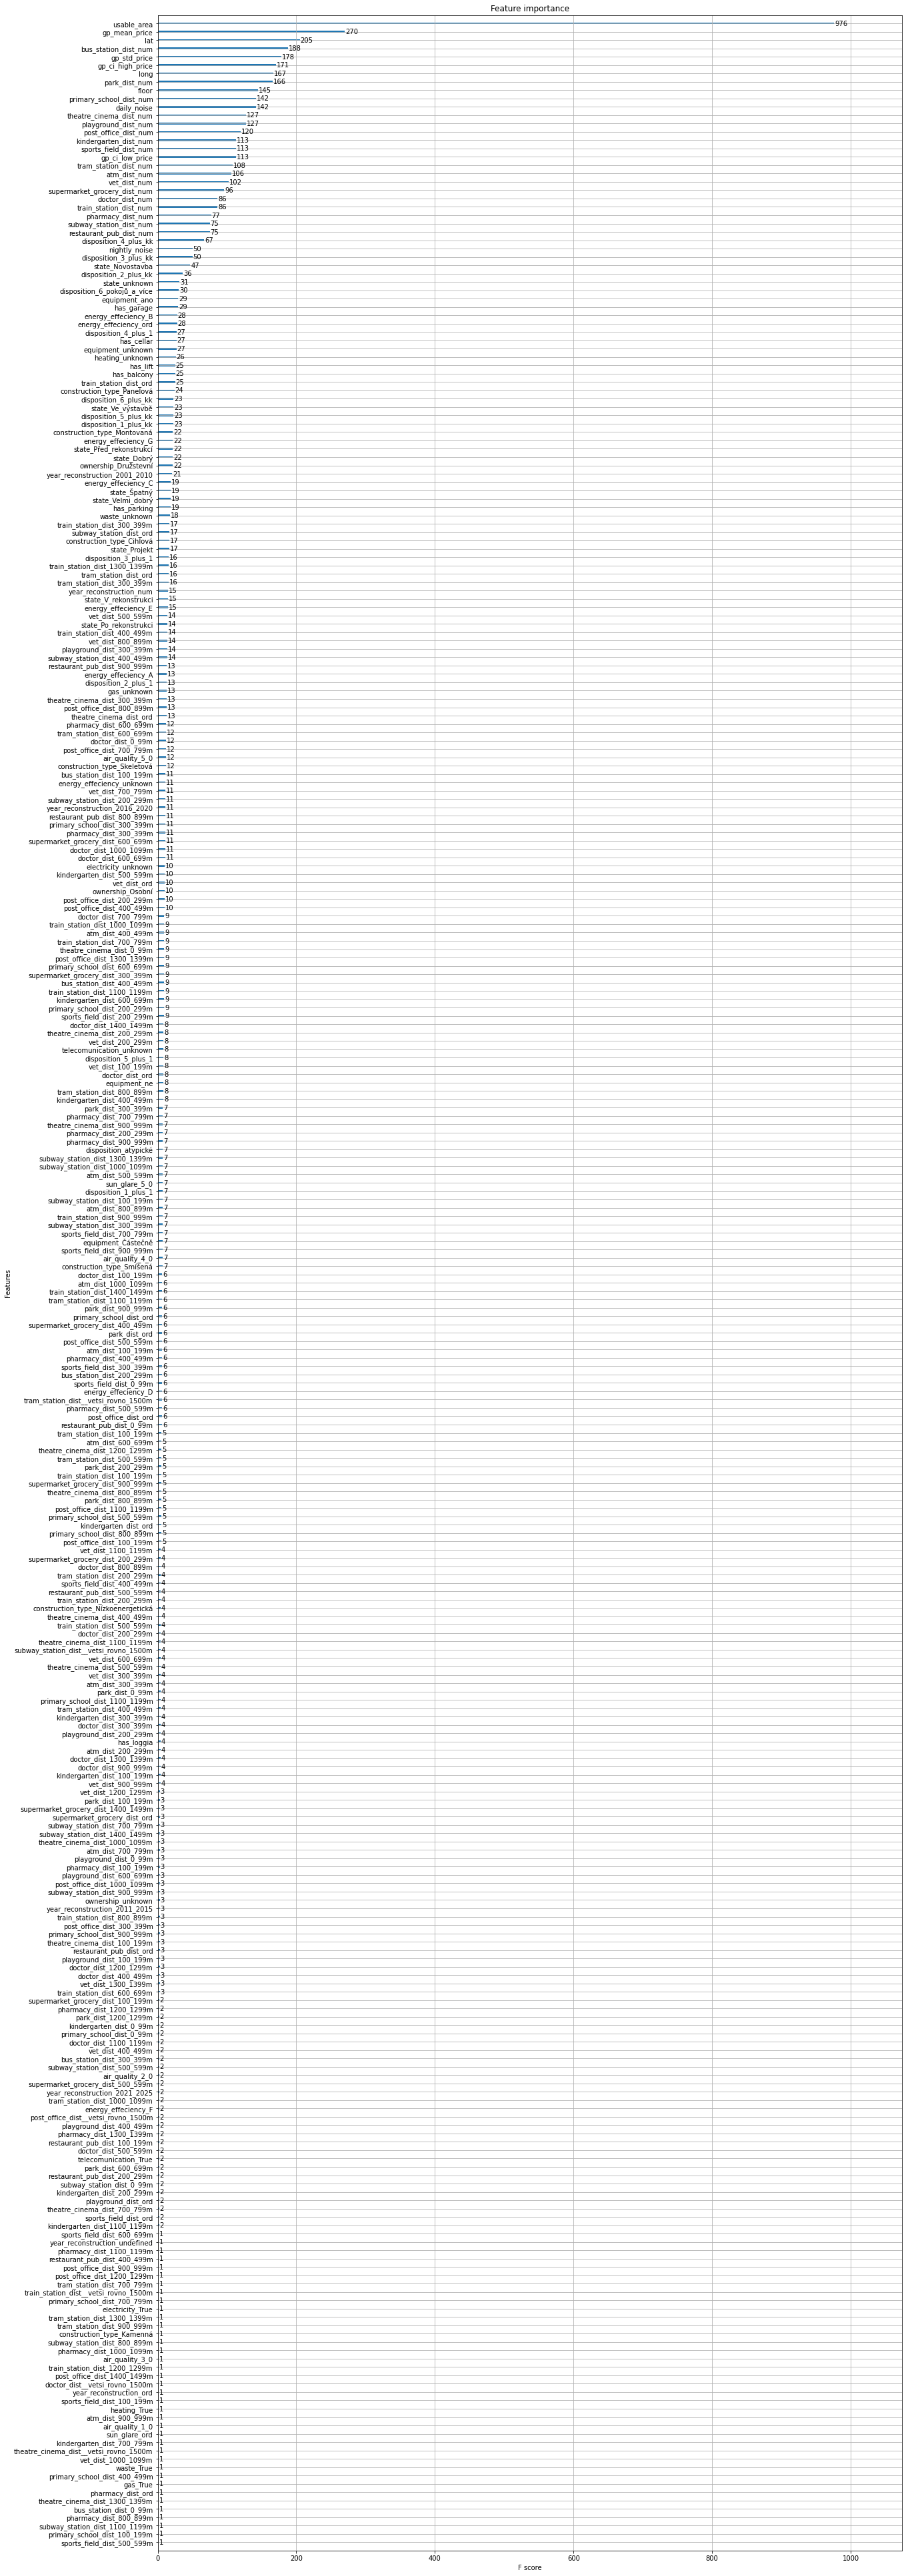

In [135]:
# https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
ax = plot_importance(basic_model)
fig = ax.figure
fig.set_size_inches(20,70)
fig.show()

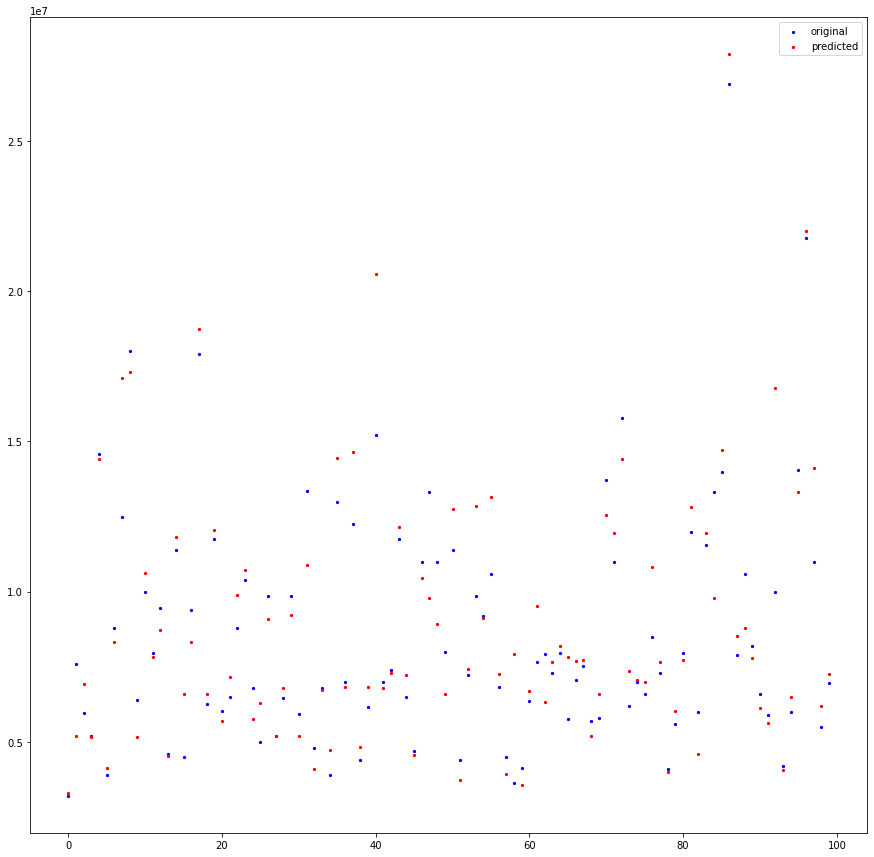

In [136]:
# x_ax = range(len(Y_test))
x_ax = range(100)
plt.rcParams["figure.figsize"] = (15, 15)
plt.scatter(x_ax, Y_test[:100], s=5, color="blue", label="original")
plt.scatter(x_ax, y_pred[:100], s=5, color="red", label="predicted")
plt.legend()
plt.show()

In [137]:
# https://www.datatechnotes.com/2019/06/regression-example-with-xgbregressor-in.html
y_pred = basic_model.predict(X_test)
mse = mean_squared_error(Y_test, y_pred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 7028728273936.41
RMSE: 2651174.89


In [138]:
'''kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, xtrain, ytrain, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())'''

'kfold = KFold(n_splits=10, shuffle=True)\nkf_cv_scores = cross_val_score(xgbr, xtrain, ytrain, cv=kfold )\nprint("K-fold CV average score: %.2f" % kf_cv_scores.mean())'

MODEL with m^2 almost the same as with the price

# MODEL with numerical distance

In [139]:
Y_num = df['price'].values.reshape(-1,1)
X_num = df.drop("price", axis=1)
X_num = X_num.drop([ord for ord in only_ord_dist], axis=1)
X_num = X_num.drop([hot for hot in only_one_hot_dist], axis=1)
X_train_num, X_test_num, Y_train_num, Y_test_num = train_test_split(X_num, Y_num, test_size=0.2, random_state=42, shuffle=True)

In [140]:
numerical_model = XGBRegressor(n_estimators = 1000,
                        boosting_type='dart',
                        learning_rate=0.09, 
                        colsample_bytree=0.96,
                        colsample_bynode=1,
                        #objective='reg:squarederror',
                        #eval_metric=mean_absolute_error,
                        max_depth=3,
                        #tree_method='hist',
                        #enable_categorical=True,
                        #subsample=0.9,
                        random_state=42, silent=True, 
                        #booster='gbtree',
                     
            early_stopping_rounds=20)
numerical_model.fit(X_train_num, Y_train_num)
y_pred_num = numerical_model.predict(X_test_num)
predictions = [round(value) for value in y_pred_num]
print("The model training score is " , numerical_model.score(X_train_num, Y_train_num))
print("The model testing score is " , numerical_model.score(X_test_num, Y_test_num))
print("The model testing mean absolute error is ", mean_absolute_error(Y_test_num, y_pred_num))
print("The model max error is ", max_error(Y_test_num, y_pred_num))
print("The model median absolute error is ", median_absolute_error(Y_test_num, y_pred_num))

The model training score is  0.9696105576691771
The model testing score is  0.8060595825782314
The model testing mean absolute error is  1149826.0898601399
The model max error is  70016516.0
The model median absolute error is  630228.5


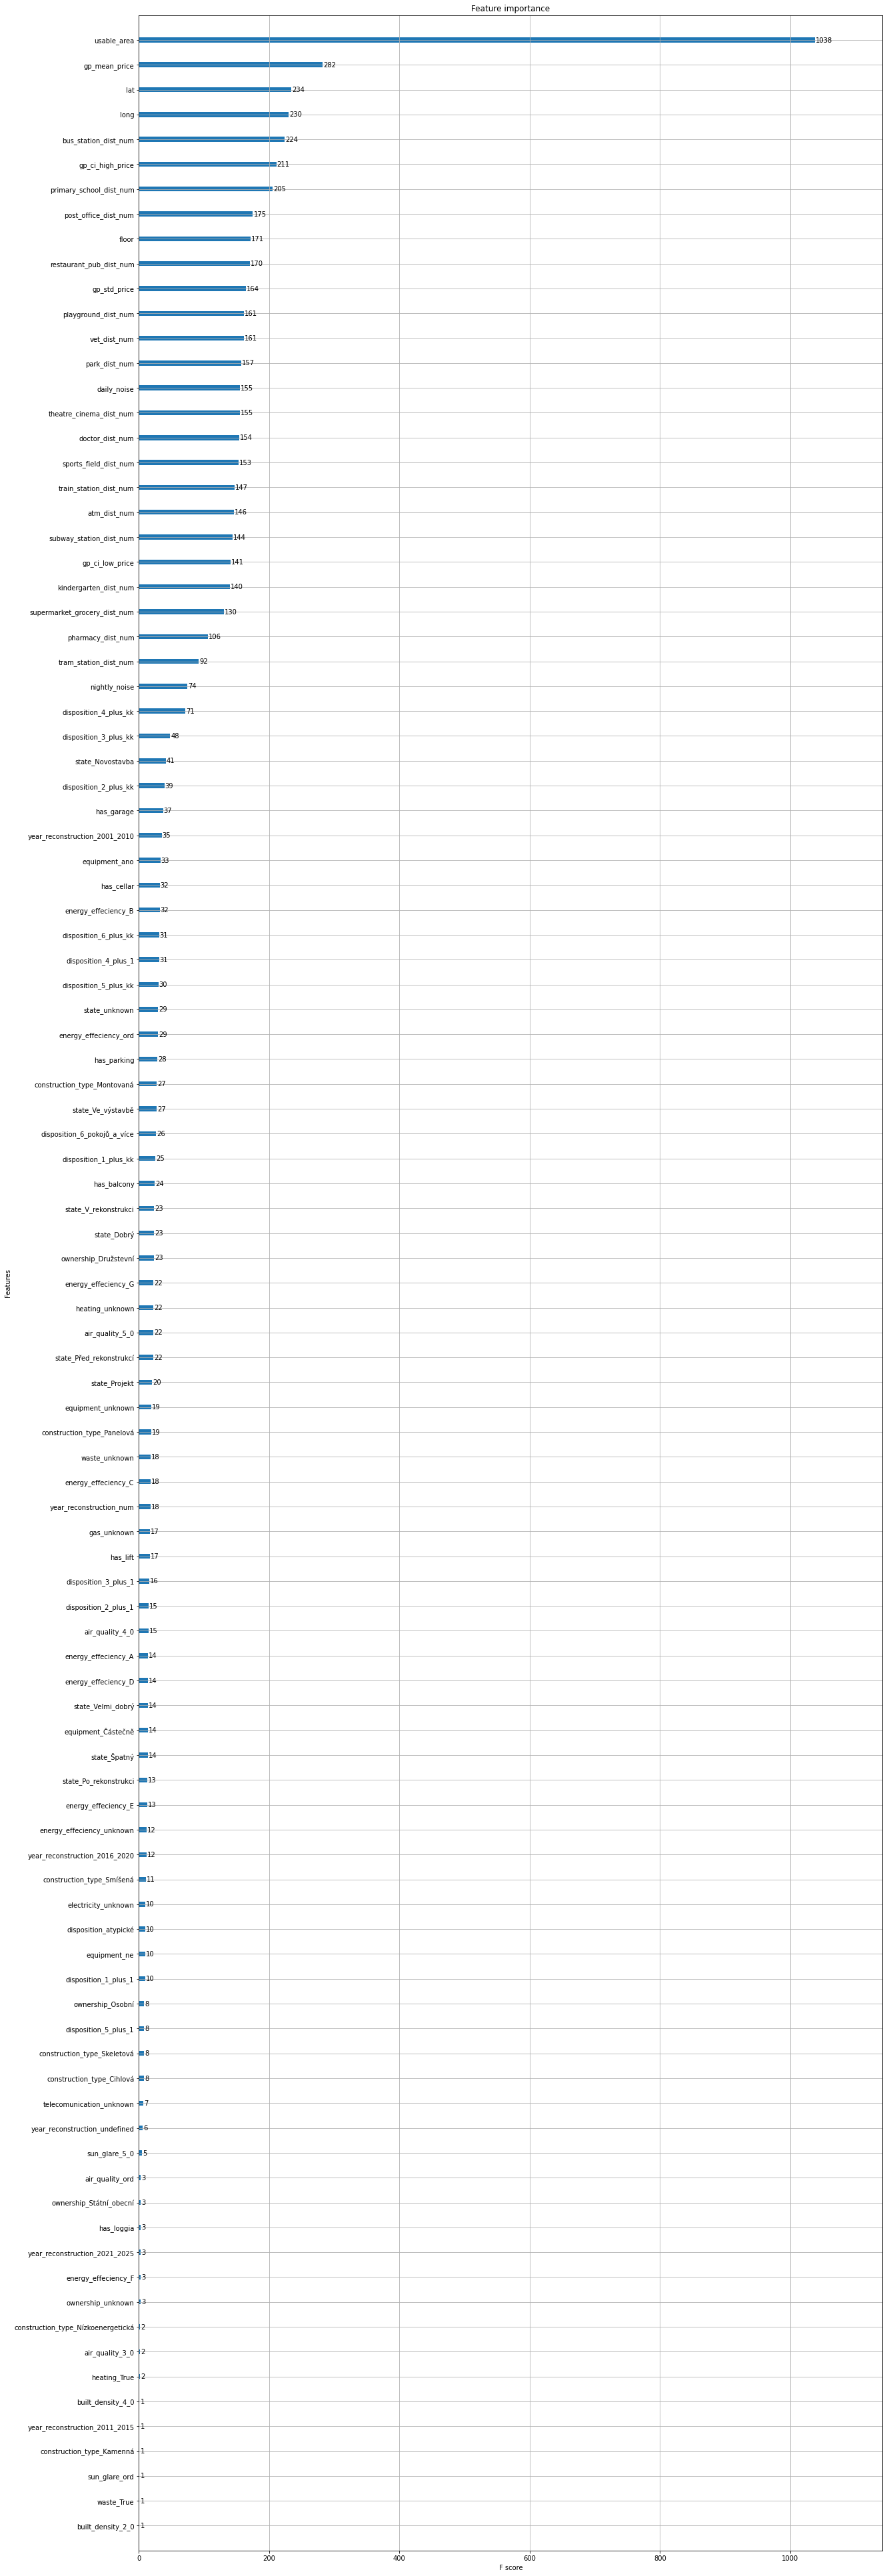

In [141]:
ax = plot_importance(numerical_model)
fig = ax.figure
fig.set_size_inches(20,70)
fig.show()

# MODEL with numerical distance without gp

In [142]:
# try model without gp
Y_num_without_gp = df['price'].values.reshape(-1,1)
X_num_without_gp = df.drop("price", axis=1)
X_num_without_gp = X_num_without_gp.drop([ord for ord in only_ord_dist], axis=1)
X_num_without_gp = X_num_without_gp.drop([hot for hot in only_one_hot_dist], axis=1)
X_num_without_gp = X_num_without_gp.drop([gp for gp in only_gp], axis=1)
X_train_num_without_gp, X_test_num_without_gp, Y_train_num_without_gp, Y_test_num_without_gp = train_test_split(X_num_without_gp, Y_num_without_gp, test_size=0.2, random_state=42, shuffle=True)
numerical_model_without_gp = XGBRegressor(n_estimators = 1000,
                        boosting_type='dart',
                        learning_rate=0.09, 
                        colsample_bytree=0.96,
                        colsample_bynode=1,
                        #objective='reg:squarederror',
                        #eval_metric=mean_absolute_error,
                        max_depth=3,
                        #tree_method='hist',
                        #enable_categorical=True,
                        #subsample=0.9,
                        random_state=42, silent=True, 
                        #booster='gbtree',
                     
            early_stopping_rounds=20)
numerical_model_without_gp.fit(X_train_num_without_gp, Y_train_num_without_gp)
y_pred_num_without_gp = numerical_model_without_gp.predict(X_test_num_without_gp)
predictions = [round(value) for value in y_pred_num_without_gp]
print("The model training score is " , numerical_model_without_gp.score(X_train_num_without_gp, Y_train_num_without_gp))
print("The model testing score is " , numerical_model_without_gp.score(X_test_num_without_gp, Y_test_num_without_gp))
print("The model testing mean absolute error is ", mean_absolute_error(Y_test_num_without_gp, y_pred_num_without_gp))
print("The model max error is ", max_error(Y_test_num_without_gp, y_pred_num_without_gp))
print("The model median absolute error is ", median_absolute_error(Y_test_num_without_gp, y_pred_num_without_gp))

The model training score is  0.9669080739303716
The model testing score is  0.8060560535183883
The model testing mean absolute error is  1182847.5333916084
The model max error is  67059656.0
The model median absolute error is  646821.5


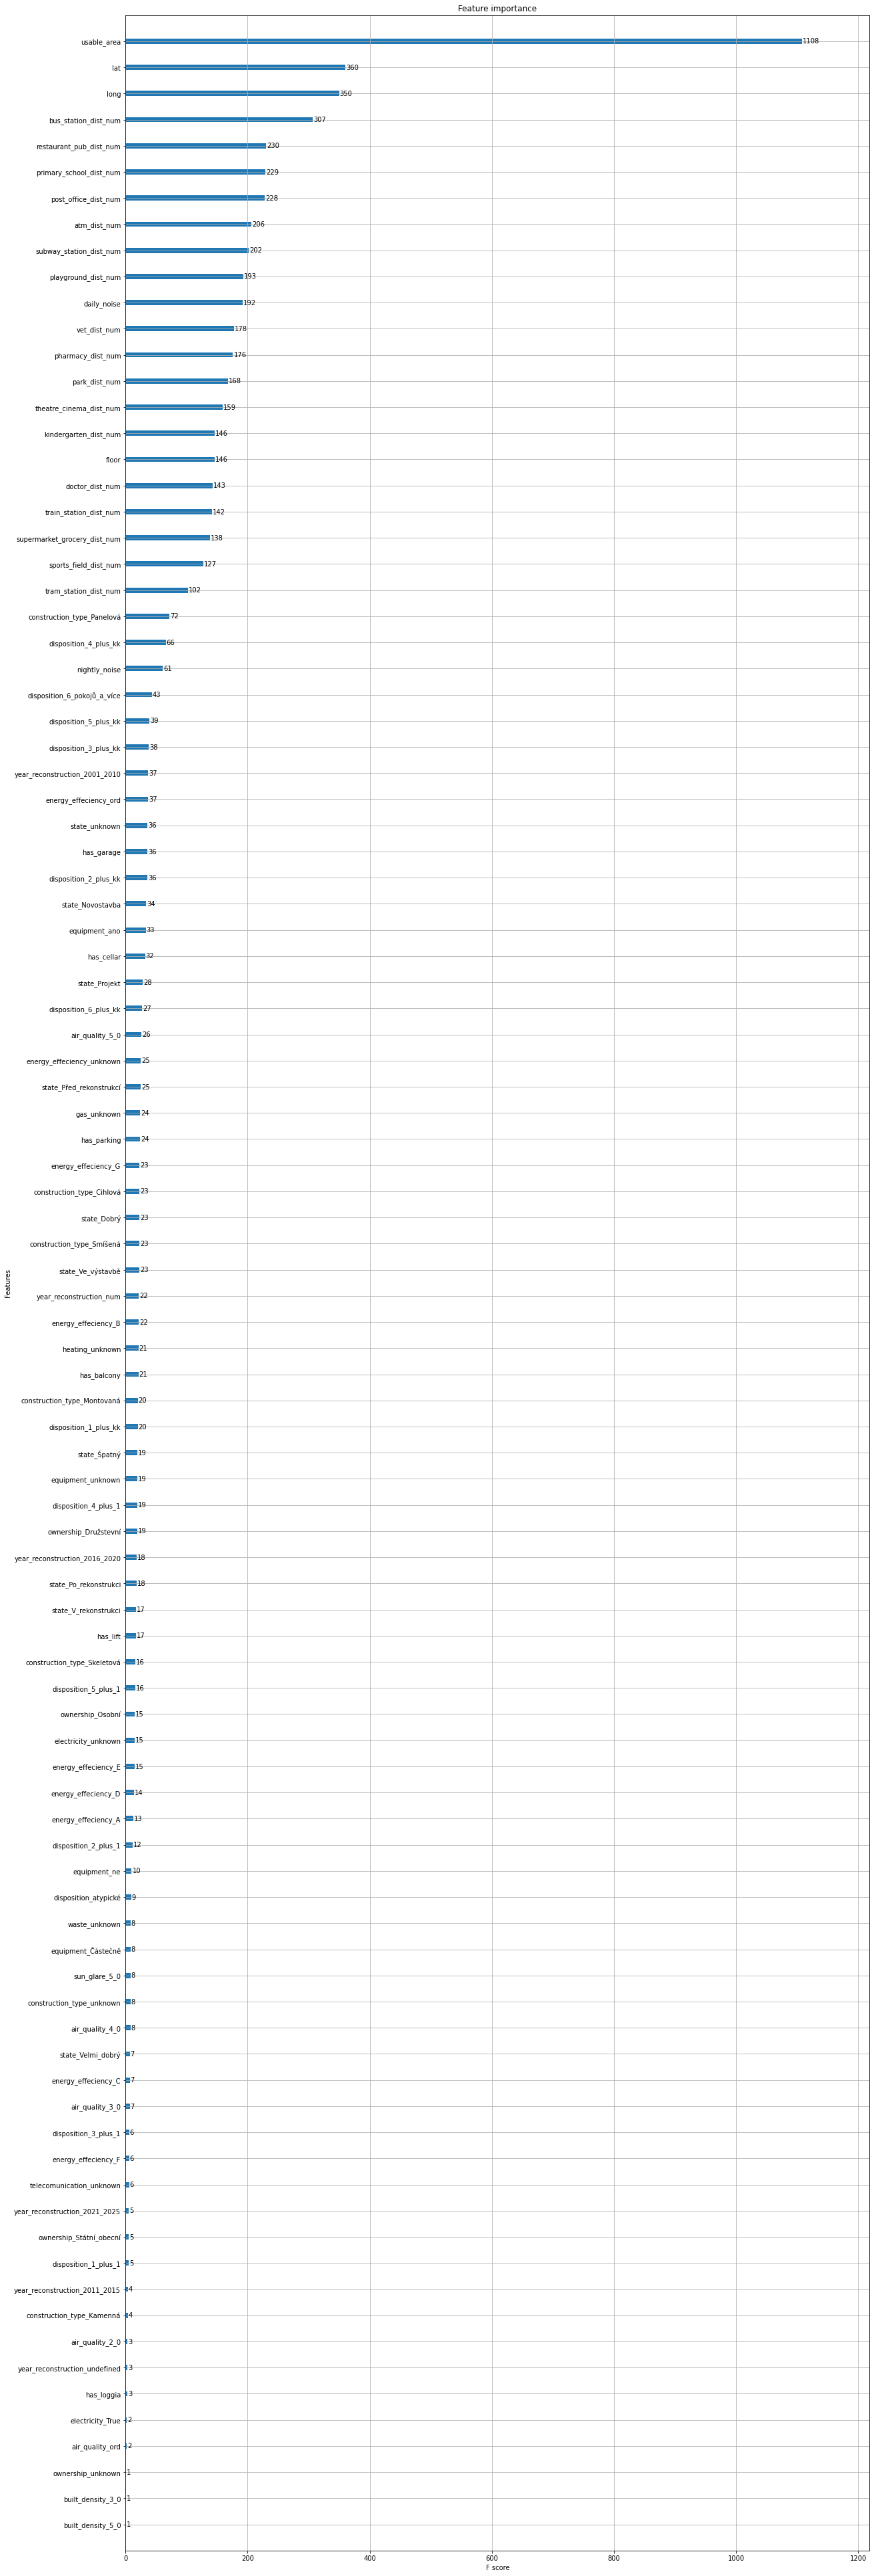

In [143]:
ax = plot_importance(numerical_model_without_gp)
fig = ax.figure
fig.set_size_inches(20,70)
fig.show()

In [144]:
X_test_num_without_gp['prediction'] = y_pred_num_without_gp
X_test_num_without_gp['true_label'] = Y_test_num
X_test_num_without_gp['error'] = abs(X_test_num_without_gp['true_label']) - abs(X_test_num_without_gp['prediction'])
X_test_num_without_gp['true_price_per_m2'] = X_test_num_without_gp['true_label']/X_test_num_without_gp['usable_area']
X_test_num_without_gp['predicted_price_per_m2'] = X_test_num_without_gp['prediction']/X_test_num_without_gp['usable_area']
X_test_num_without_gp['error_per_m2'] = abs(X_test_num_without_gp['true_price_per_m2']) - abs(X_test_num_without_gp['predicted_price_per_m2'])
# pro kladné = podceněné, pro záporné nadceněné
# podceněné byty o 750 000
# X_test_num_without_gp[X_test_num_without_gp.error > 750000] 
fig = px.box(X_test_num_without_gp, y="error_per_m2")
fig.show()

In [145]:
X_test_num_without_gp[X_test_num_without_gp.error_per_m2 > 45000] # 133 pozorování
# není to tím usable area

,daily_noise,nightly_noise,energy_effeciency_unknown,energy_effeciency_G,energy_effeciency_E,energy_effeciency_B,energy_effeciency_D,energy_effeciency_C,energy_effeciency_A,energy_effeciency_F,ownership_Osobní,ownership_Státní_obecní,ownership_Družstevní,ownership_unknown,equipment_unknown,equipment_ne,equipment_Částečně,equipment_ano,state_unknown,state_V_rekonstrukci,state_Před_rekonstrukcí,state_Po_rekonstrukci,state_Novostavba,state_Velmi_dobrý,state_Dobrý,state_Ve_výstavbě,state_Projekt,state_Špatný,disposition_unknown,disposition_1_plus_kk,disposition_1_plus_1,disposition_3_plus_1,disposition_3_plus_kk,disposition_2_plus_kk,disposition_4_plus_1,disposition_2_plus_1,disposition_5_plus_kk,disposition_4_plus_kk,disposition_atypické,disposition_6_pokojů_a_více,disposition_5_plus_1,disposition_6_plus_kk,construction_type_unknown,construction_type_Cihlová,construction_type_Smíšená,construction_type_Panelová,construction_type_Skeletová,construction_type_Kamenná,construction_type_Montovaná,construction_type_Nízkoenergetická,construction_type_Drevostavba,year_reconstruction_mensi1950,year_reconstruction_1951_1980,year_reconstruction_1981_2000,year_reconstruction_2001_2010,year_reconstruction_2011_2015,year_reconstruction_2016_2020,year_reconstruction_2021_2025,year_reconstruction_undefined,air_quality_unknown,air_quality_1_0,air_quality_2_0,air_quality_3_0,air_quality_4_0,air_quality_5_0,built_density_unknown,built_density_1_0,built_density_2_0,built_density_3_0,built_density_4_0,built_density_5_0,sun_glare_unknown,sun_glare_1_0,sun_glare_2_0,sun_glare_3_0,sun_glare_4_0,sun_glare_5_0,gas_unknown,gas_True,gas_False,waste_unknown,waste_True,waste_False,telecomunication_unknown,telecomunication_True,telecomunication_False,electricity_unknown,electricity_True,electricity_False,heating_unknown,heating_True,heating_False,usable_area,floor,long,lat,has_lift,has_garage,has_cellar,no_barriers,has_loggia,has_balcony,has_garden,has_parking,bus_station_dist_num,train_station_dist_num,subway_station_dist_num,tram_station_dist_num,post_office_dist_num,atm_dist_num,doctor_dist_num,vet_dist_num,primary_school_dist_num,kindergarten_dist_num,supermarket_grocery_dist_num,restaurant_pub_dist_num,playground_dist_num,sports_field_dist_num,theatre_cinema_dist_num,pharmacy_dist_num,park_dist_num,year_reconstruction_num,year_reconstruction_ord,energy_effeciency_ord,air_quality_ord,built_density_ord,sun_glare_ord,prediction,true_label,error,true_price_per_m2,predicted_price_per_m2,error_per_m2
3713,75.0,70.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,41.0,1.0,14.481240,50.092448,False,False,False,True,False,True,False,False,488.000000,1721.000000,1312.000000,27.000000,750.000000,407.000000,1004.000000,439.000000,289.000000,210.000000,761.000000,512.000000,221.000000,240.000000,967.000000,582.000000,259.511653,0.0,0,7,4.0,4.0,4.0,5071684.5,7588160.0,2516475.5,185077.073171,123699.621951,61377.451220
3641,55.0,50.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,37.0,8.0,14.396894,50.071761,True,False,True,True,False,True,False,False,145.000000,1203.000000,509.000000,263.000000,392.000000,435.000000,351.000000,463.000000,196.000000,372.000000,522.000000,200.000000,213.000000,62.000000,569.000000,419.000000,186.825746,0.0,0,7,5.0,5.0,5.0,7121541.0,8900000.0,1778459.0,240540.540541,192474.081081,48066.459459
1145,55.0,50.0,1.0,0.0,0.0,0.0,0.0

In [146]:
X_test_num_without_gp[X_test_num_without_gp.error_per_m2 < -46000] # 28 pozorování

,daily_noise,nightly_noise,energy_effeciency_unknown,energy_effeciency_G,energy_effeciency_E,energy_effeciency_B,energy_effeciency_D,energy_effeciency_C,energy_effeciency_A,energy_effeciency_F,ownership_Osobní,ownership_Státní_obecní,ownership_Družstevní,ownership_unknown,equipment_unknown,equipment_ne,equipment_Částečně,equipment_ano,state_unknown,state_V_rekonstrukci,state_Před_rekonstrukcí,state_Po_rekonstrukci,state_Novostavba,state_Velmi_dobrý,state_Dobrý,state_Ve_výstavbě,state_Projekt,state_Špatný,disposition_unknown,disposition_1_plus_kk,disposition_1_plus_1,disposition_3_plus_1,disposition_3_plus_kk,disposition_2_plus_kk,disposition_4_plus_1,disposition_2_plus_1,disposition_5_plus_kk,disposition_4_plus_kk,disposition_atypické,disposition_6_pokojů_a_více,disposition_5_plus_1,disposition_6_plus_kk,construction_type_unknown,construction_type_Cihlová,construction_type_Smíšená,construction_type_Panelová,construction_type_Skeletová,construction_type_Kamenná,construction_type_Montovaná,construction_type_Nízkoenergetická,construction_type_Drevostavba,year_reconstruction_mensi1950,year_reconstruction_1951_1980,year_reconstruction_1981_2000,year_reconstruction_2001_2010,year_reconstruction_2011_2015,year_reconstruction_2016_2020,year_reconstruction_2021_2025,year_reconstruction_undefined,air_quality_unknown,air_quality_1_0,air_quality_2_0,air_quality_3_0,air_quality_4_0,air_quality_5_0,built_density_unknown,built_density_1_0,built_density_2_0,built_density_3_0,built_density_4_0,built_density_5_0,sun_glare_unknown,sun_glare_1_0,sun_glare_2_0,sun_glare_3_0,sun_glare_4_0,sun_glare_5_0,gas_unknown,gas_True,gas_False,waste_unknown,waste_True,waste_False,telecomunication_unknown,telecomunication_True,telecomunication_False,electricity_unknown,electricity_True,electricity_False,heating_unknown,heating_True,heating_False,usable_area,floor,long,lat,has_lift,has_garage,has_cellar,no_barriers,has_loggia,has_balcony,has_garden,has_parking,bus_station_dist_num,train_station_dist_num,subway_station_dist_num,tram_station_dist_num,post_office_dist_num,atm_dist_num,doctor_dist_num,vet_dist_num,primary_school_dist_num,kindergarten_dist_num,supermarket_grocery_dist_num,restaurant_pub_dist_num,playground_dist_num,sports_field_dist_num,theatre_cinema_dist_num,pharmacy_dist_num,park_dist_num,year_reconstruction_num,year_reconstruction_ord,energy_effeciency_ord,air_quality_ord,built_density_ord,sun_glare_ord,prediction,true_label,error,true_price_per_m2,predicted_price_per_m2,error_per_m2
2903,75.0,70.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,48.0,6.0,14.457393,50.082374,True,False,True,True,False,True,False,False,55.000000,1546.000000,503.000000,65.000000,432.000000,113.000000,926.000000,484.000000,157.000000,54.000000,390.000000,43.000000,78.000000,100.000000,514.000000,385.000000,169.041254,2019.0,6,4,4.0,4.0,4.0,7043408.5,4490000.0,-2553408.5,93541.666667,146737.677083,-53196.010417
1613,45.0,40.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,33.0,3.0,14.399229,50.054838,True,False,False,True,False,False,False,False,93.000000,955.000000,820.000000,670.000000,1538.000000,816.000000,1074.000000,1082.000000,491.000000,138.000000,788.000000,313.000000,382.000000,447.000000,1939.000000,1553.000000,626.657254,0.0,0,3,3.0,3.0,3.0,5538104.0,3900000.0,-1638104.0,118181.818182,167821.333333,-49639.515152
4707,60.0,55.0,1.0,0.0,0.0,0.0

# MODEL with ordinal without gp

In [160]:
# try model without gp
Y_ord_without_gp = df['price'].values.reshape(-1,1)
X_ord_without_gp = df.drop("price", axis=1)
X_ord_without_gp = X_ord_without_gp.drop([num for num in only_num_dist], axis=1)
missing = ['bus_station_dist__vetsi_rovno_1500m', 'train_station_dist__vetsi_rovno_1500m', 'subway_station_dist__vetsi_rovno_1500m', 'tram_station_dist__vetsi_rovno_1500m', 'post_office_dist__vetsi_rovno_1500m', 'atm_dist__vetsi_rovno_1500m', 'doctor_dist__vetsi_rovno_1500m', 'vet_dist__vetsi_rovno_1500m', 'primary_school_dist__vetsi_rovno_1500m', 'kindergarten_dist__vetsi_rovno_1500m', 'supermarket_grocery_dist__vetsi_rovno_1500m', 'restaurant_pub_dist__vetsi_rovno_1500m', 'playground_dist__vetsi_rovno_1500m', 'sports_field_dist__vetsi_rovno_1500m', 'theatre_cinema_dist__vetsi_rovno_1500m', 'pharmacy_dist__vetsi_rovno_1500m', 'park_dist__vetsi_rovno_1500m']
new_list = [fruit for fruit in only_one_hot_dist if fruit not in missing]
X_ord_without_gp = X_ord_without_gp.drop([one for one in new_list], axis=1)
X_ord_without_gp = X_ord_without_gp.drop([gp for gp in only_gp], axis=1)
X_train_ord_without_gp, X_test_ord_without_gp, Y_train_ord_without_gp, Y_test_ord_without_gp = train_test_split(X_ord_without_gp, Y_ord_without_gp, test_size=0.2, random_state=42, shuffle=True)
ordinal_model_without_gp = XGBRegressor(n_estimators = 1000,
                        boosting_type='dart',
                        learning_rate=0.09, 
                        colsample_bytree=0.96,
                        colsample_bynode=1,
                        #objective='reg:squarederror',
                        #eval_metric=mean_absolute_error,
                        max_depth=3,
                        #tree_method='hist',
                        #enable_categorical=True,
                        #subsample=0.9,
                        random_state=42, silent=True, 
                        #booster='gbtree',
                     
            early_stopping_rounds=20)
ordinal_model_without_gp.fit(X_train_ord_without_gp, Y_train_ord_without_gp)
y_pred_ord_without_gp = ordinal_model_without_gp.predict(X_test_ord_without_gp)
predictions = [round(value) for value in y_pred_ord_without_gp]
print("The model training score is " , ordinal_model_without_gp.score(X_train_ord_without_gp, Y_train_ord_without_gp))
print("The model testing score is " , ordinal_model_without_gp.score(X_test_ord_without_gp, Y_test_ord_without_gp))
print("The model testing mean absolute error is ", mean_absolute_error(Y_test_ord_without_gp, y_pred_ord_without_gp))
print("The model max error is ", max_error(Y_test_ord_without_gp, y_pred_ord_without_gp))
print("The model median absolute error is ", median_absolute_error(Y_test_ord_without_gp, y_pred_ord_without_gp))

The model training score is  0.9598514458114372
The model testing score is  0.8005385294710777
The model testing mean absolute error is  1173821.7902972028
The model max error is  69601880.0
The model median absolute error is  638802.0


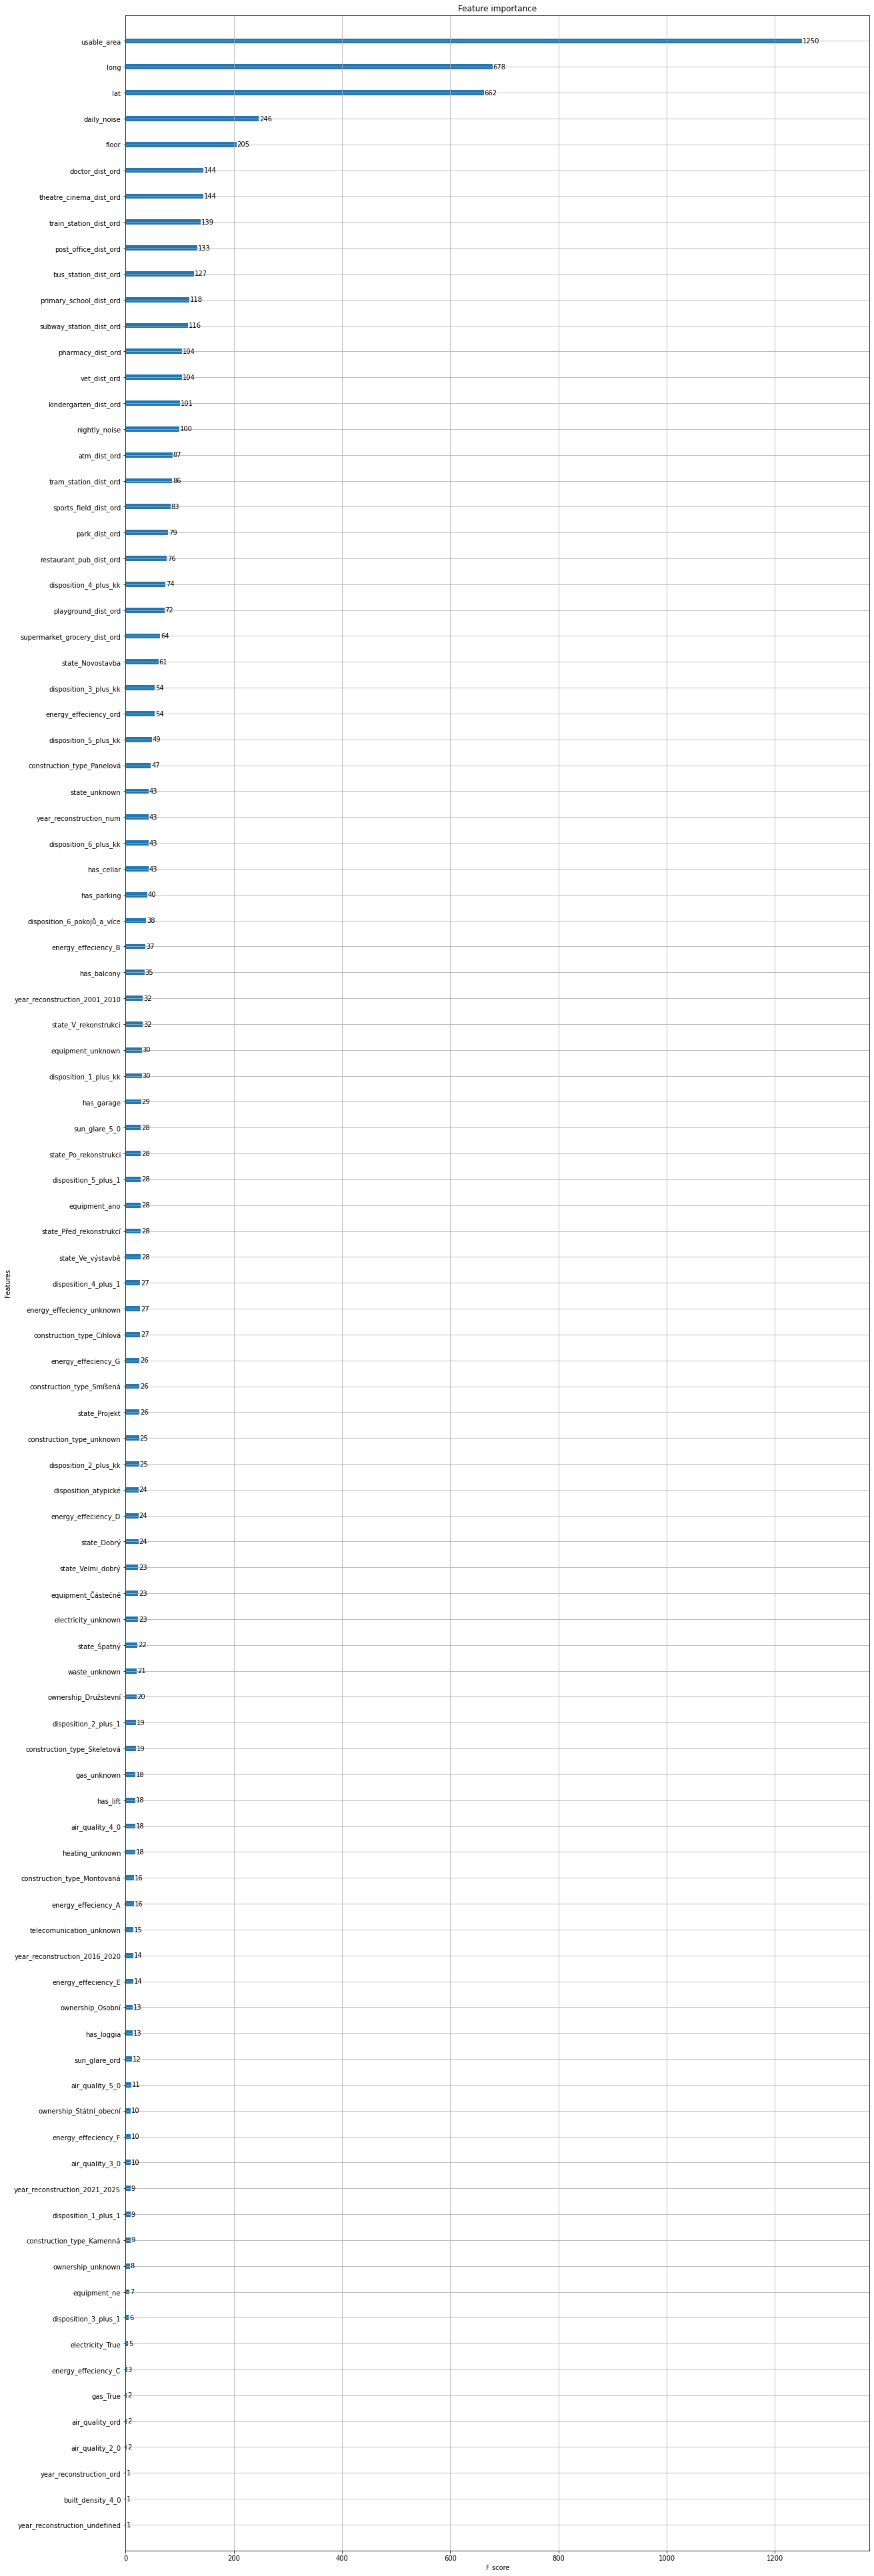

In [161]:
ax = plot_importance(ordinal_model_without_gp)
fig = ax.figure
fig.set_size_inches(20,70)
fig.show()

# MODEL with onehot - from importance features we can see, that onehot for distance aren't significant

# MODEL with monotonic constrains

In [162]:
constraints = []
for i in range(421):
  constraints.append(0)
colNames = df.columns[df.columns.str.contains(pat = 'noise')]
print(colNames)
# give column name
col_name = "daily_noise"
# find the index no
index_no = df.columns.get_loc(col_name)
print(index_no)
col_name = "nightly_noise"
index_no = df.columns.get_loc(col_name)
print(index_no)
constraints[0] = -1
constraints[1] = -1

Index(['daily_noise', 'nightly_noise'], dtype='object')
0
1


In [163]:
'''params_constrained = params.copy()
params_constrained['monotone_constraints'] = constraints'''

"params_constrained = params.copy()\nparams_constrained['monotone_constraints'] = constraints"

# MODEL with target-encoding

# RANDOM SEARCH of the 'best model'

# GRID SEARCH of the 'best model'

# BAYES. SEARCH of the 'best model'